# Electional Astrology

City position data from _The Global Airport Database_.  
http://www.partow.net/miscellaneous/airportdatabase/index.html#Downloads

In [1]:
# create a calendar
from datetime import date, timedelta
import pandas as pd

now = date.today()
now_date = now.strftime('%Y/%m/%d')
end = now + timedelta(days=365) # length of prediction
end_date = end.strftime('%Y/%m/%d ')

range = pd.date_range(now_date, end_date)
df = pd.DataFrame(index=range)
df['date_string'] = df.index.strftime('%Y/%m/%d ')

In [2]:
from flatlib.datetime import Datetime
from flatlib.geopos import GeoPos
from flatlib.chart import Chart
from flatlib import const

pos = GeoPos(51.424264, -0.072600) #london

In [3]:
def make_chart(date):
    date = Datetime(date)
    return Chart(date, pos)

In [4]:
def get_object(chart, planet):
    for obj in chart.objects:
        if obj.id == planet:
            return obj

### Getting Married
from: Orion, R. (2007) _Astrology for Dummies_, 2nd Ed. John Wiley & Sons. (p.281)

> + Make certain that Venus, the planet of love, is direct. If it happens to be retrograde, postpone your wedding for a few weeks.

In [5]:
def must_be_direct(row, planet, GO='GO'):
    chart = make_chart(row['date_string'])
    planet = get_object(chart, planet)
    movement = planet.movement()
    if GO == 'GO':
        if movement == "Direct":
            return planet.lonspeed
        else: 
            return 0
    elif GO == 'NOGO':
        if movement != "Direct":
            return 1
        else: 
            return 0

df['venus_direct GO'] = df.apply(lambda row: must_be_direct(row, 'Venus', GO='GO'), axis = 1)
df['venus_direct NOGO'] = df.apply(lambda row: must_be_direct(row, 'Venus', GO='NOGO'), axis = 1)


In [6]:
df.head()

date_string  venus_direct GO  venus_direct NOGO
2018-04-10  2018/04/10          1.226635                  0
2018-04-11  2018/04/11          1.226040                  0
2018-04-12  2018/04/12          1.225440                  0
2018-04-13  2018/04/13          1.224833                  0
2018-04-14  2018/04/14          1.224220                  0

array([<matplotlib.axes._subplots.AxesSubplot object at 0x10c086278>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1112e36a0>], dtype=object)

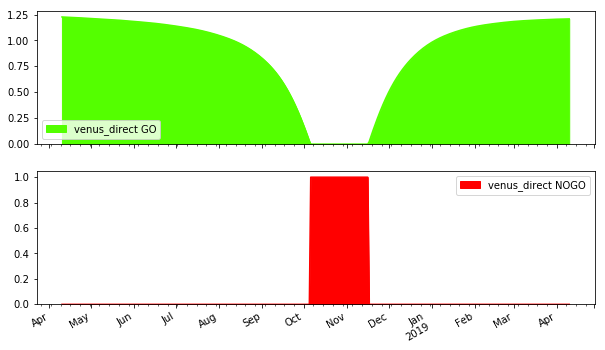

In [7]:
%matplotlib inline
df.plot.area(subplots=True, figsize=(10,6), colormap='prism_r')

> + Choose a day when Mercury is direct, not retrograde. With retrograde Mercury, misunderstandings and problems in communication are likely to arise, either immediately or down the line. Also, it’s never a good idea to sign a contract when Mercury is retrograde. Marriage, whatever else it may be, is a legal agreement — and you _will_ have to sign on the dotted line.

In [8]:
df['mercury_direct GO'] = df.apply(lambda row: must_be_direct(row, 'Mercury', GO='GO'), axis = 1)
df['mercury_direct NOGO'] = df.apply(lambda row: must_be_direct(row, 'Mercury', GO='NOGO'), axis = 1)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1114b2fd0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11165ca58>], dtype=object)

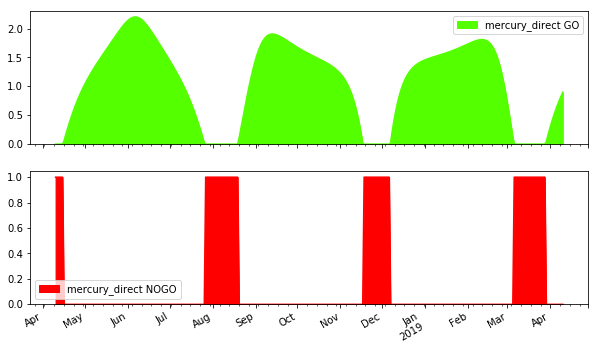

In [9]:
mercury_df = df[['mercury_direct GO','mercury_direct NOGO']]
mercury_df.plot.area(subplots=True, figsize=(10,6), colormap='prism_r')

> + Choose the position of the Moon with care. A New Moon, with the Sun and the Moon conjunct, classically signals a new beginning. The best possible Moon for a wedding is a New Moon in your sign (or your partner’s), in your seventh house of marriage, or in Libra.

In [10]:
def new_moon(row, moon_in = 'Libra'):
    chart = make_chart(row['date_string'])
    day_after = row.name + timedelta(days = 1)
    date_after = day_after.strftime('%Y/%m/%d')
    next_chart = make_chart(date_after)
    
    moon = get_object(chart, 'Moon')    
    moon_phase = chart.getMoonPhase()
    next_moon_phase = next_chart.getMoonPhase()

    moon_score = 0
    
    if moon_phase != "First Quarter" and next_moon_phase == "First Quarter":
        moon_score += 1
        if moon.sign == moon_in:
            moon_score += 1
    return moon_score
    
df['new_moon GO'] = df.apply(lambda row: new_moon(row), axis = 1)

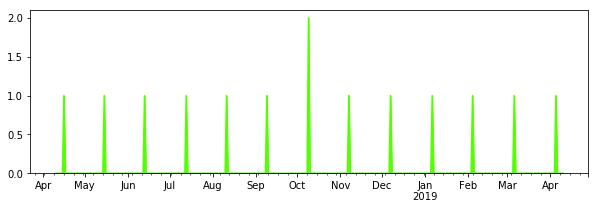

In [11]:
new_moon_df = df['new_moon GO']
new_moon_df.plot.area(figsize=(10,3), colormap='prism_r')

> + If a New Moon isn’t possible, for whatever reasons, at least get married when the Moon is waxing — that is, when it’s between New and Full, becoming larger and more luminous every night. A waning Moon has passed its peak of luminosity and is on the downward slide, getting smaller and dimmer every moment. Who needs that symbolism?

In [12]:
from flatlib import angle

def waxing_moon(row):
    chart = make_chart(row['date_string'])
    moon = get_object(chart, 'Moon')
    moon_phase = chart.getMoonPhase()
    sun = get_object(chart, 'Sun')
    
    if moon_phase in ['First Quarter', 'Second Quarter']:
        # maximum after new moon, decreases after that
        return 180 - angle.distance(sun.lon, moon.lon)
    else:
        return 0
    
df['waxing_moon GO'] = df.apply(lambda row: waxing_moon(row), axis = 1)

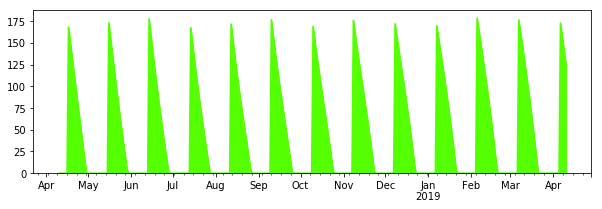

In [13]:
waxing_moon_df = df['waxing_moon GO']
waxing_moon_df.plot.area(figsize=(10,3), colormap='prism_r')

> + Look for an auspicious angle between the Sun and the Moon. A sextile (60°) or trine (120°) creates harmony. A tight 90° square or 180° opposition generates tension and conflict.

In [14]:
from flatlib.aspects import hasAspect, getAspect, aspectType
from flatlib import props

aspect_names = props.aspect.name

def auspicious_angle(row, planet1, planet2, GO="GO"):
    chart = chart = make_chart(row['date_string'])
    p1 = get_object(chart, planet1)
    p2 = get_object(chart, planet2)
    
    aspect = aspectType(p1, p2, aspect_names)
    
    if GO == "GO":
        angles = [60, 120] 
    elif GO == "NOGO":
        angles = [90, 180]
    
    if aspect in angles:
        return 1
    else:
        return 0

df['sun_moon_angle GO'] = df.apply(lambda row: auspicious_angle(row, 'Moon', 'Sun'), axis = 1)
df['sun_moon_angle NOGO'] = df.apply(lambda row: auspicious_angle(row, 'Moon', 'Sun', GO='NOGO'), axis = 1)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x114ee69b0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x114ff8e80>], dtype=object)

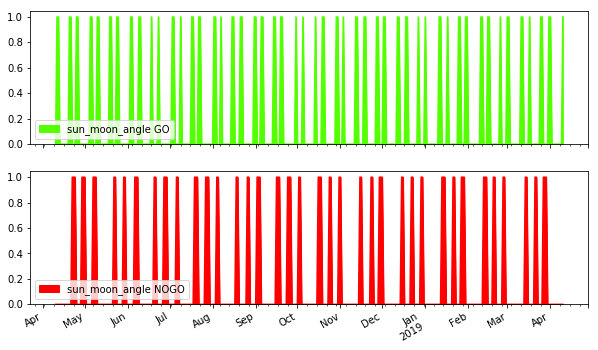

In [15]:
sun_moon_angle_df = df[['sun_moon_angle GO','sun_moon_angle NOGO']]
sun_moon_angle_df.plot.area(subplots=True, figsize=(10,6), colormap='prism_r')

> + Look for trines and sextiles involving the Moon, Venus, and Jupiter — the more the better.

In [16]:
import itertools

def count_trines_sextiles(row, planets):
    '''count trines and sextiles between (3+) planets in array'''
    chart = make_chart(row['date_string'])
    bodies = []
    for planet in planets:
        bodies.append(get_object(chart, planet))
    
    trines_sextiles = 0
    for a, b in itertools.combinations(bodies, 2):
        aspect = aspectType(a, b, aspect_names)
        if aspect in [60, 120]:
            trines_sextiles += 1
        
    return trines_sextiles 

df['MVJ_trines_sextiles GO'] = df.apply(lambda row: count_trines_sextiles(row, ['Moon', 'Venus', 'Jupiter']), axis = 1)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x115142588>], dtype=object)

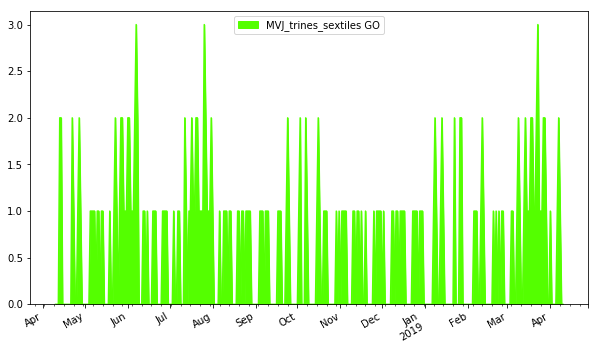

In [17]:
MVJ_df = df[['MVJ_trines_sextiles GO']]
MVJ_df.plot.area(subplots=True, figsize=(10,6), colormap='prism_r')

> + Make sure the Moon isn’t void-of-course. And make sure that your schedule has room for error, just in case the flower girl is late.

> The Moon is void-of-course when it has made its last major aspect in one sign but has not yet entered the next. The void-of-course period always comes at the end of the Moon’s journey through a sign. To avoid a void-of-course Moon, schedule an event shortly after the Moon enters a new sign.

In [18]:
def void_of_course(row):
    chart = make_chart(row['date_string'])
    moon = get_object(chart, 'Moon')
    
    day_after = row.name + timedelta(days = 1)
    date_after = day_after.strftime('%Y/%m/%d')
    next_chart = make_chart(date_after)
    next_moon = get_object(next_chart, 'Moon')
    
    if moon.sign != next_moon.sign:
        return 1
    else:
        return 0

df['moon_VOC NOGO'] = df.apply(lambda row: void_of_course(row), axis = 1)

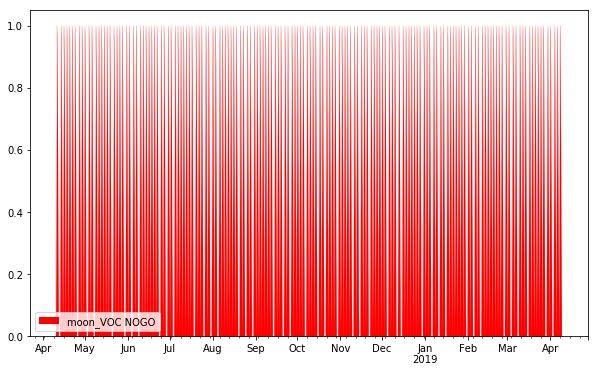

In [19]:
VOC_df = df[['moon_VOC NOGO']]
VOC_df.plot.area(use_index=True, figsize=(10,6), colormap='prism', lw=0.1)

In [20]:
df.head()

date_string  venus_direct GO  venus_direct NOGO  \
2018-04-10  2018/04/10          1.226635                  0   
2018-04-11  2018/04/11          1.226040                  0   
2018-04-12  2018/04/12          1.225440                  0   
2018-04-13  2018/04/13          1.224833                  0   
2018-04-14  2018/04/14          1.224220                  0   

            mercury_direct GO  mercury_direct NOGO  new_moon GO  \
2018-04-10                0.0                    1            0   
2018-04-11                0.0                    1            0   
2018-04-12                0.0                    1            0   
2018-04-13                0.0                    1            0   
2018-04-14                0.0                    1            0   

            waxing_moon GO  sun_moon_angle GO  sun_moon_angle NOGO  \
2018-04-10             0.0                  0                    0   
2018-04-11             0.0                  1                    0   
2018-04-12             0.0                  1                    0   
2018-04-13             0.0                  0                    0   
2018-04-14             0.0                  0                    0   

            MVJ_trines_sextiles GO  moon_VOC NOGO  
2018-04-10                       0              0  
2018-04-11                       0              1  
2018-04-12                       0              0  
2018-04-13                       2              0  
2018-04-14                       2              1

## all together

In [21]:
# get rid of the column with dates as strings
# this was only useful to generate the charts
df.drop(['date_string'], axis=1, inplace=True)

In [22]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
df_scaled.head()

venus_direct GO  venus_direct NOGO  mercury_direct GO  \
2018-04-10         1.000000                0.0                0.0   
2018-04-11         0.999515                0.0                0.0   
2018-04-12         0.999025                0.0                0.0   
2018-04-13         0.998530                0.0                0.0   
2018-04-14         0.998031                0.0                0.0   

            mercury_direct NOGO  new_moon GO  waxing_moon GO  \
2018-04-10                  1.0          0.0             0.0   
2018-04-11                  1.0          0.0             0.0   
2018-04-12                  1.0          0.0             0.0   
2018-04-13                  1.0          0.0             0.0   
2018-04-14                  1.0          0.0             0.0   

            sun_moon_angle GO  sun_moon_angle NOGO  MVJ_trines_sextiles GO  \
2018-04-10                0.0                  0.0                0.000000   
2018-04-11                1.0                  0.0                0.000000   
2018-04-12                1.0                  0.0                0.000000   
2018-04-13                0.0                  0.0                0.666667   
2018-04-14                0.0                  0.0                0.666667   

            moon_VOC NOGO  
2018-04-10            0.0  
2018-04-11            1.0  
2018-04-12            0.0  
2018-04-13            0.0  
2018-04-14            1.0

In [23]:
go_cols = df_scaled.filter(like=" GO", axis = 1)
nogo_cols = df_scaled.filter(like="NOGO", axis = 1)
df_scaled['total_GO'] = go_cols.sum(axis=1)
df_scaled['total_NOGO'] = nogo_cols.sum(axis=1)
scores_df  = df_scaled[['total_GO', 'total_NOGO']]

In [24]:
scores_df = pd.DataFrame(scaler.fit_transform(scores_df), columns=scores_df.columns, index=scores_df.index)

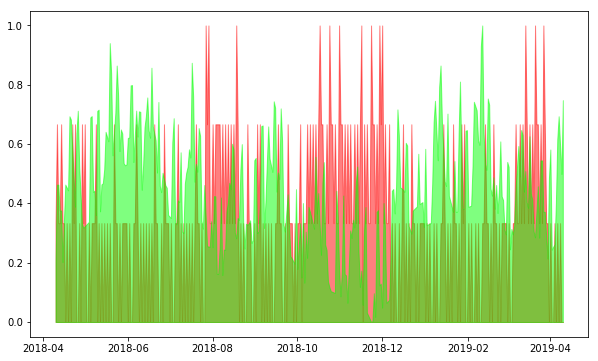

In [25]:
from matplotlib import pyplot as plt

transp = 0.5
plt.figure(figsize=(10,6))

def plot(col, colour):
    #plt.plot(scores_df.index, scores_df[col], c=colour, lw=0.2)
    plt.fill_between(scores_df.index, scores_df[col],0, color=colour)

plot('total_NOGO', (1,0,0,transp))
plot('total_GO', (0,1,0,transp))
plt.show()

In [26]:
scores_df['score'] = scores_df['total_GO'] - scores_df['total_NOGO']
scores_df.drop(['total_GO', 'total_NOGO'], axis=1, inplace = True)

The best dates to get married in the coming year.

In [27]:
scores_df.sort_values(by='score', ascending=False).head()

score
2019-02-10  0.929256
2018-05-20  0.837882
2019-01-26  0.810771
2018-06-04  0.799093
2018-06-03  0.797874

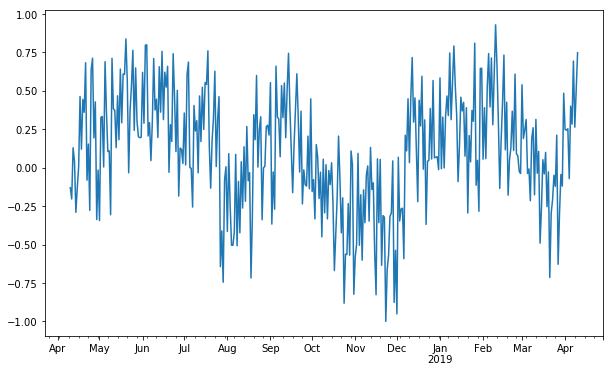

In [28]:
scores_df['score'].plot(figsize=(10,6))